<a href="https://colab.research.google.com/github/martydom/Corona-Virus-Tweet-Sentiment-Analysis/blob/main/Devashish_Bose_Team_1_Coronavirus_Tweet_Sentiment_Analysis_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

We have 6 Features but only considering 4 of them to analyze our tweets

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
!pip install catboost
!pip install sentistrength

In [96]:
#Class for Storing Fitted Models
import pickle
class save_model:
  def __init__ (self,filepath):
    self.filepath = filepath

  def load(self,name = None):
    '''
    Name : if you know the name you can extract the exact model, else you can give a specific name to extract that model.
    '''
    model_file = open(self.filepath,'rb')
    try:
      models =  pickle.load(model_file)
    except:
      model_file = {}
    model_file.close()
    if name:
      return models[name]
    else:
      return models
    

  def save(self,model,name):
    try:
      models = self.load()
    except:
      models = {}
    models[name] = model
    model_file = open(self.filepath,'wb')
    pickle.dump(models,model_file)
    model_file.close()
    return f'Dumped Model {name}'
    
  def delete(self,name):
    try:
      models = self.load()
    except:
      return f'No Models in dump'
    try:
      models.pop(name)
    except:
      return f"ENTER A VALID NAME"
    model_file = open(self.filepath,'wb')
    pickle.dump(models,model_file)
    model_file.close()
    return f'{name} Deleted'

sm = save_model('/content/drive/MyDrive/AlmaBetter/Module 4/Week 1/model_dump_self')

In [97]:
# Function to do Gridsearch_CV, To be used with Load and Store Fucnction
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import train_test_split
def gscv(model_dict,X,y):
  '''
  Input model_dict = {model_name:[model,param_dict,scoring_]
  '''
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)
  models = {'model': [], 'train_time': [],'train_accuracy': [], 'train_precision': [], 'train_recall': [], 'train_f1_score': [], 'train_tn fp fn tp': [], 'train_auc_roc': [], 'test_accuracy': [], 'test_precision': [], 'test_recall': [], 'test_f1_score': [], 'test_tn fp fn tp': [], 'test_auc_roc': []}
  for k in model_dict.keys():
    gs_model = GridSearchCV(estimator = model_dict[k][0], param_grid= model_dict[k][1], scoring=model_dict[k][2], n_jobs= -1,cv=5,)
    training_time = time.time()
    gs_model.fit(X_train,y_train)
    training_time = time.time() - training_time
    sm.save(gs_model,k)
    models['model'].append(k)
    models['train_time'].append(training_time)
    y_pred_test = gs_model.predict(X_test)
    y_pred_train = gs_model.predict(X_train)
    models['train_accuracy'].append(accuracy_score(y_train,y_pred_train))
    models['train_precision'].append(precision_score(y_train,y_pred_train,average='weighted'))
    models['train_recall'].append(recall_score(y_train,y_pred_train,average='weighted'))
    models['train_f1_score'].append(f1_score(y_train,y_pred_train,average='weighted'))
    models['train_tn fp fn tp'].append(confusion_matrix(y_train,y_pred_train).flatten())
    # models['train_auc_roc'].append(roc_auc_score(y_train,y_pred_train,average='weighted', multi_class='ovr'))
    models['test_accuracy'].append(accuracy_score(y_test,y_pred_test))
    models['test_precision'].append(precision_score(y_test,y_pred_test,average='weighted'))
    models['test_recall'].append(recall_score(y_test,y_pred_test,average='weighted'))
    models['test_f1_score'].append(f1_score(y_test,y_pred_test,average='weighted'))
    models['test_tn fp fn tp'].append(confusion_matrix(y_test,y_pred_test).flatten())
    # models['test_auc_roc'].append(roc_auc_score(y_test,y_pred_test,average='weighted',multi_class='ovr'))
  data = pd.DataFrame(models)
  sm.save(data,"Final Result")
  return data

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(30,12)})
from sklearn.metrics import *

In [99]:
df = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4/Week 1/Coronavirus Tweets.csv', encoding= 'latin-1')

In [100]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Null Values for Location

In [102]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Associating a score to sentiment of tweets

In [103]:
df['Ordinal_Sentiment'] = df['Sentiment'].replace({"Positive":1,'Negative':-1,'Neutral':0,'Extremely Positive':2,'Extremely Negative':-2})

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


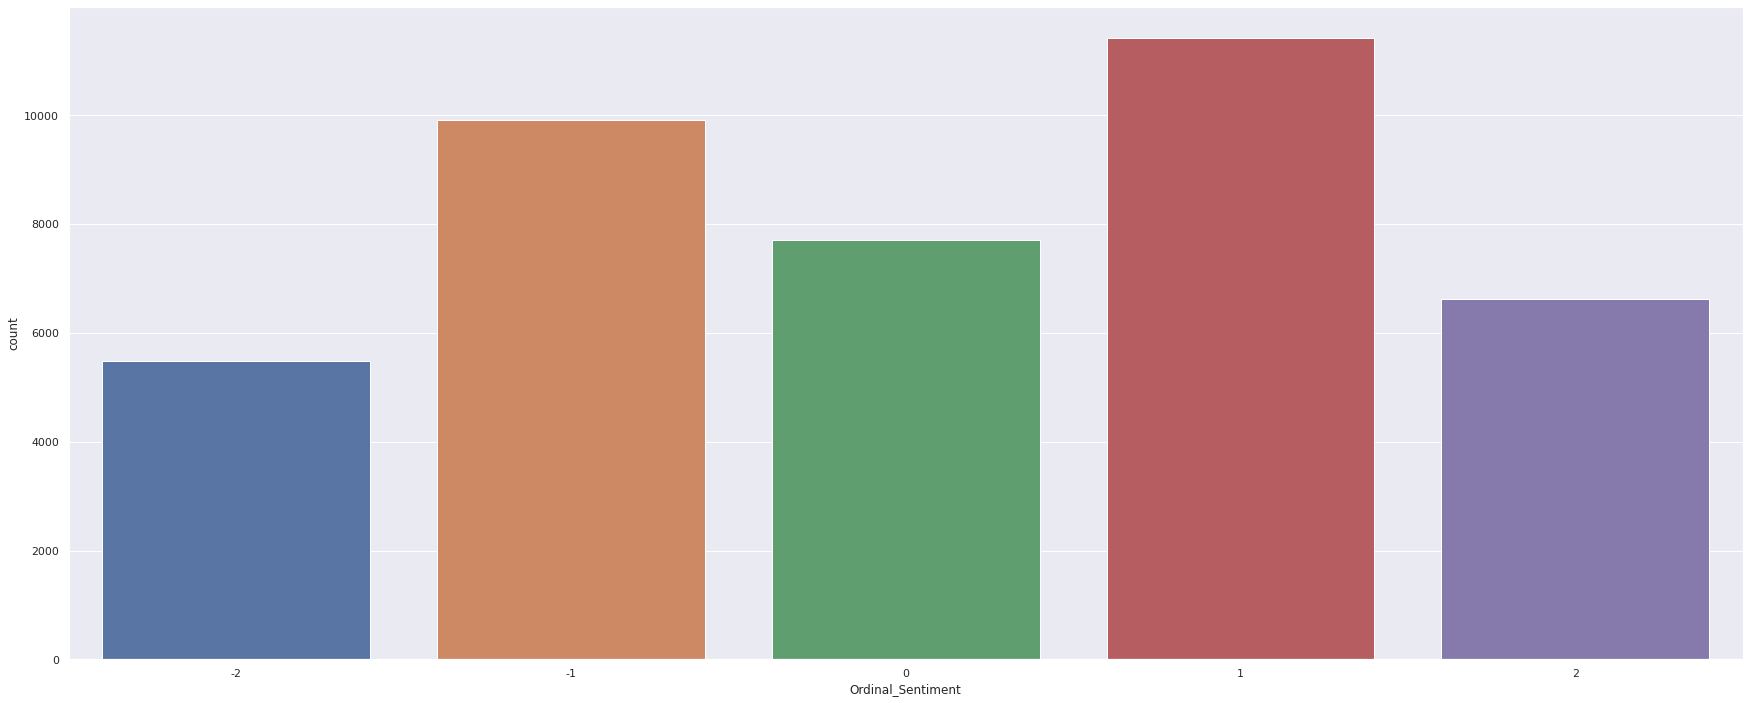

In [104]:
sns.countplot(df['Ordinal_Sentiment'])

Plotting Data according to date.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

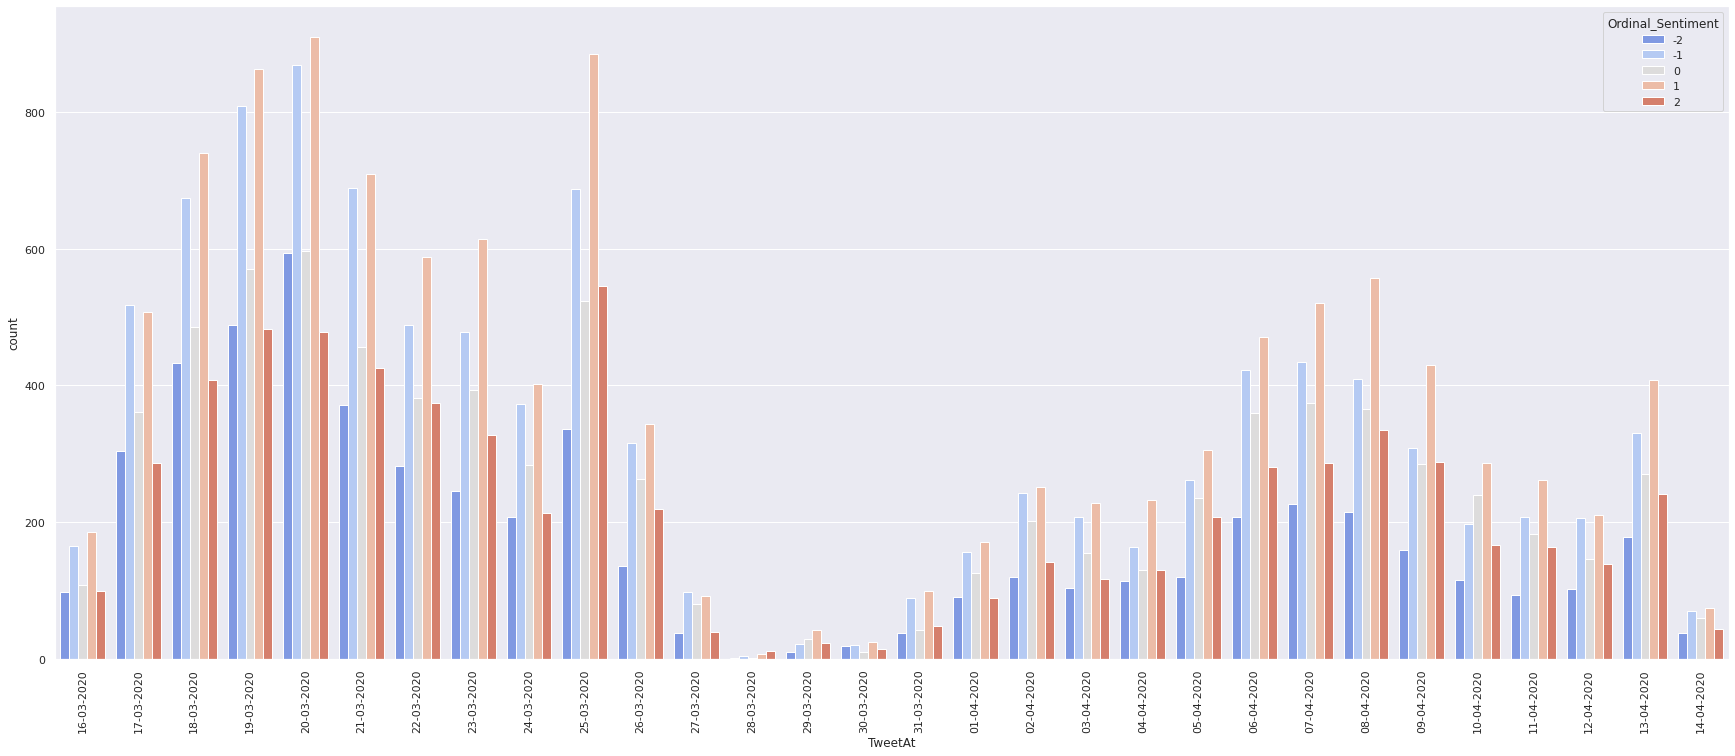

In [105]:
sns.countplot(df['TweetAt'],hue=df['Ordinal_Sentiment'],palette = 'coolwarm')
plt.xticks(rotation = 90)

In [106]:
df['Location'].value_counts()

London                         540
United States                  528
London, England                520
New York, NY                   395
Washington, DC                 373
                              ... 
NJ raised | FL livinÂ           1
Waukesha, WI                     1
Buffalo, NY & Erie, PA           1
Brighton, Hove & Birmingham      1
Cornwall England                 1
Name: Location, Length: 12220, dtype: int64

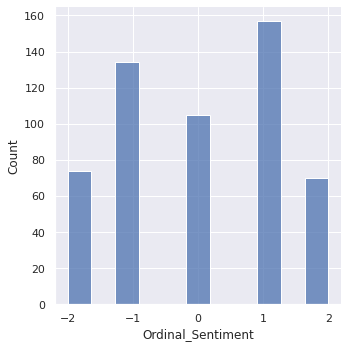

In [107]:
sns.displot(df[df['Location']=='London']['Ordinal_Sentiment'])

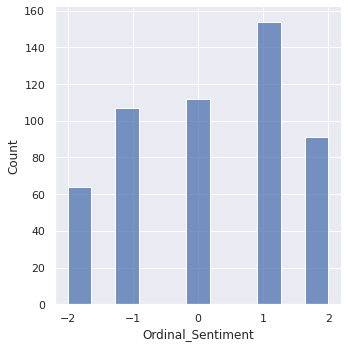

In [108]:
sns.displot(df[df['Location']=='United States']['Ordinal_Sentiment'])

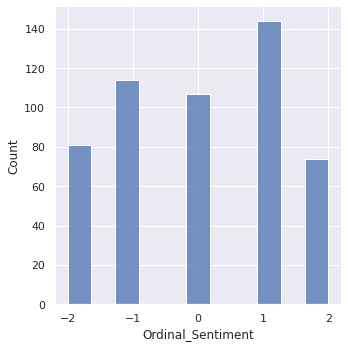

In [109]:
sns.displot(df[df['Location']=='London, England']['Ordinal_Sentiment'])

Although Location an be a factor affecting the tweet sentiments, we have too many to be handled.

If there Could be a way to segregate them using Countries, it would be a great way.

In [110]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'Ordinal_Sentiment'],
      dtype='object')

Wacthing And trying to guess random tweets

In [111]:
def guess_tweet():
  r=np.random.randint(0,df.shape[0])
  a,b = df.loc[r,['OriginalTweet','Ordinal_Sentiment']]
  print(a)
  guess = int(input('Enter Your guess: '))
  if guess == b:
    print('Congrats you are right')
  else:
    print(f"You're wrong the original sentiment score is {b}")

  return None

In [112]:
# guess_tweet()
# guess_tweet()
# guess_tweet()
# guess_tweet()
# guess_tweet()
# guess_tweet()
# guess_tweet()

We See a Pattern here, that the tweets have sentiment according to some words it contain. If it's something good because of corona it stays in the postive side. else in the negative side
We will dive deep into it tomorrow

# **Day2**

Transforming Data

**removing used data to free up memory

In [113]:
X_date = pd.get_dummies(df['TweetAt'],prefix='is_date')
value_counts_for_date = list(df['TweetAt'].value_counts().sort_index())
sum_x_date = sum(value_counts_for_date)
for i,c in enumerate(X_date.columns):
  X_date[c].replace({1:value_counts_for_date[i]/sum_x_date},inplace=True)

In [114]:
del value_counts_for_date,sum_x_date

Cleaning the Original Tweets.

In [115]:
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def preprocess(raw_text):
    raw_text = rm_links_and_ids(raw_text)
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)
    words = letters_only_text.lower().split()
    cleaned_words = []
    lemmatizer = PorterStemmer() #plug in here any other stemmer or lemmatiser you want to try out
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    # stemm or lemmatise words
    stemmed_words = []
    for word in cleaned_words:
        word = lemmatizer.stem(word)   #dont forget to change stem to lemmatize if you are using a lemmatizer
        stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [116]:
#@title Naive Code
def rm_links_and_ids(tweet):
  a=[]
  for word in tweet.split():
    if word.startswith('https:') or word.startswith('http:') or word.startswith('@'):
      continue
    else:
      a.append(word)
  return ' '.join(a)
# def rm_escape_chars(tweet):
#   return tweet.replace('/r',' ').replace('/n',' ')
# def rem_pun(tweet):
#   stri = ''
#   for i in tweet:
#     if i not in punc:
#       stri+=i
#     else:
#       stri+=' '
#   return stri
def get_tags(tweet):
  stri = ''
  for word in tweet.lower().split():
    if word.startswith("#"):
      stri+=word[1:]+' '
  return stri[:-1]
def rm_sw(tweet):
  a= []
  sw = stopwords.words('english')
  for word in tweet.lower().split():
    if word.startswith('#'):
      continue
    if word not in sw:
      a.append(word)
  return ' '.join(a)
# punc = string.punctuation.replace('#','')
# punc
def replace_cov(tweet):
  words = []
  for word in tweet.split():
    if 'corona' in word or 'covid' in word:
      words.append('corona')
      continue
    words.append(word)
  return ' '.join(words)

In [117]:
df['hashtags'] = df['OriginalTweet'].apply(get_tags).apply(preprocess).apply(replace_cov)

In [118]:
df['words'] = df['OriginalTweet'].apply(rm_sw).apply(preprocess).apply(replace_cov)

In [119]:
# df['hashtags'] = df['filtered_tweets'].apply(get_tags)
# df['words'] = df['filtered_tweets'].apply(rm_sw)
# ot,ht,w=df.loc[np.random.randint(0,df.shape[0]),['OriginalTweet','hashtags','words']]
# print(f'Original Tweet:{ot}\nHashtag:{ht}\nWords:{w}')

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [121]:
vect_ht = TfidfVectorizer(min_df=0.01,ngram_range=(1,2))
vect_word = TfidfVectorizer(min_df=0.05, ngram_range=(1,3))

In [122]:
# w_vect = TfidfVectorizer(min_df=10)

In [123]:
tweet_df = pd.concat([pd.DataFrame(data = vect_ht.fit_transform(df['hashtags']).toarray(),columns=vect_ht.get_feature_names()),
                      pd.DataFrame(data = vect_word.fit_transform(df['words']).toarray(),columns=vect_word.get_feature_names())],axis=1)

In [124]:
# w_df = pd.DataFrame(data = X_w.toarray(), columns=w_vect.get_feature_names())

In [125]:
# w_df.head()

In [126]:
# new_df = pd.concat([X_date,ht_df,w_df,df['Ordinal_Sentiment']],axis=1)
# new_df.head()

Analyzing the new Df

In [127]:
# Ram Crashes For operations Like these
# new_df[new_df['Ordinal_Sentiment']==-2].sum(axis=0).sort_values(ascending=False)[:50]

In [128]:
#plotwords(df['column'])
from wordcloud import WordCloud
def plotwords(df_column):
  all_words = '' 
  #looping through all incidents and joining them to one text, to extract most common words
  for arg in df_column: 

      tokens = arg.split()  
        
      all_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 1000, height = 1000, 
                  background_color ='white', 
                  min_font_size = 10).generate(all_words) 
    
  # plot the WordCloud image                        
  plt.figure(figsize = (10, 10), facecolor = "black") 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  plt.show()

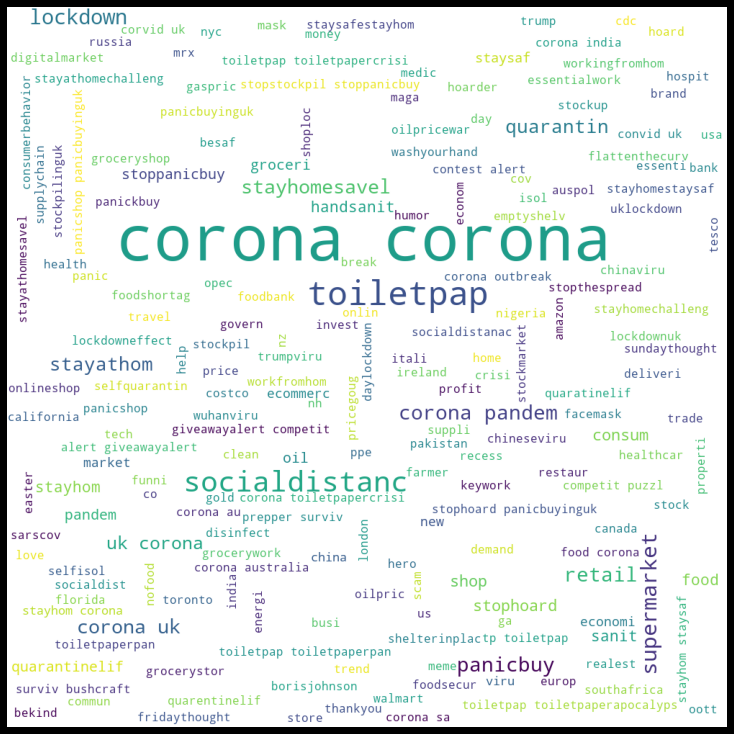

In [129]:
# All Hashtags
plotwords(df['hashtags'])

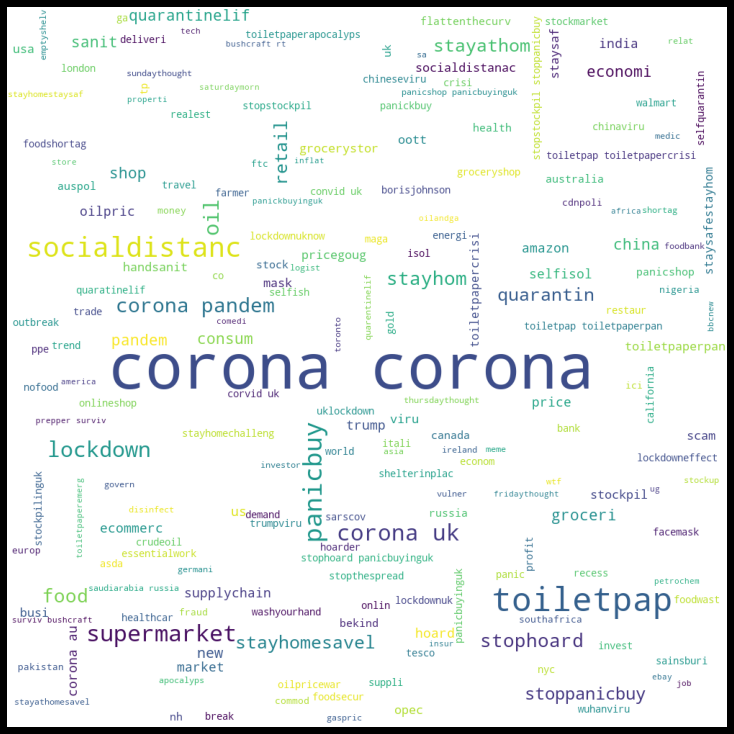

In [130]:
#Negative hashtags
plotwords(df[df['Ordinal_Sentiment']<0]['hashtags'])

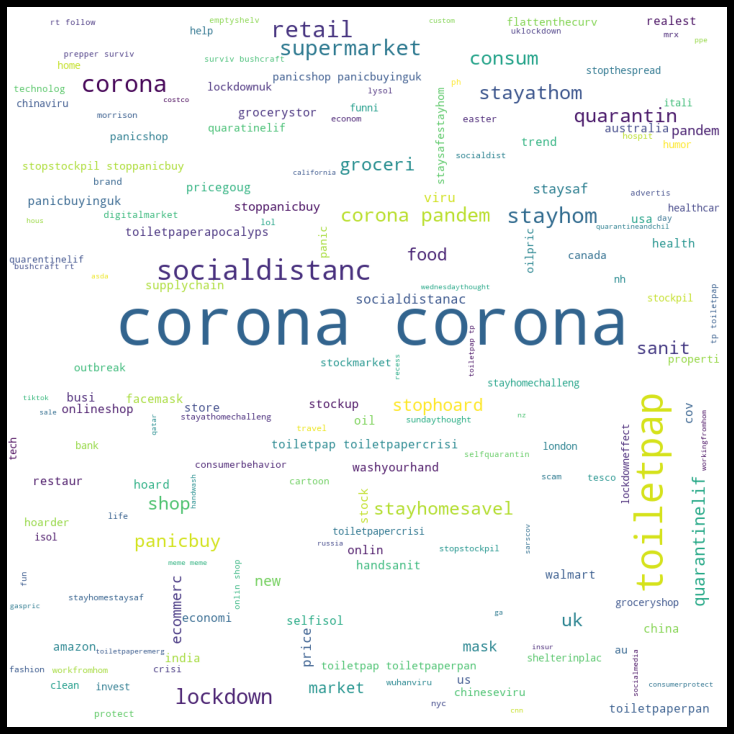

In [131]:
#Neutral Hashtags
plotwords(df[df['Ordinal_Sentiment']==0]['hashtags'])

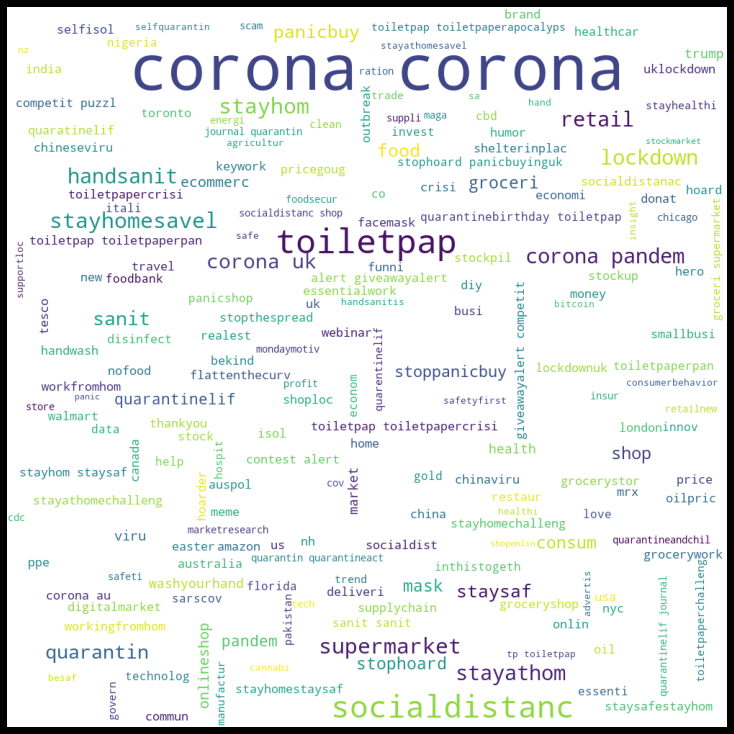

In [132]:
#Positive Hashtags
plotwords(df[df['Ordinal_Sentiment']>0]['hashtags'])

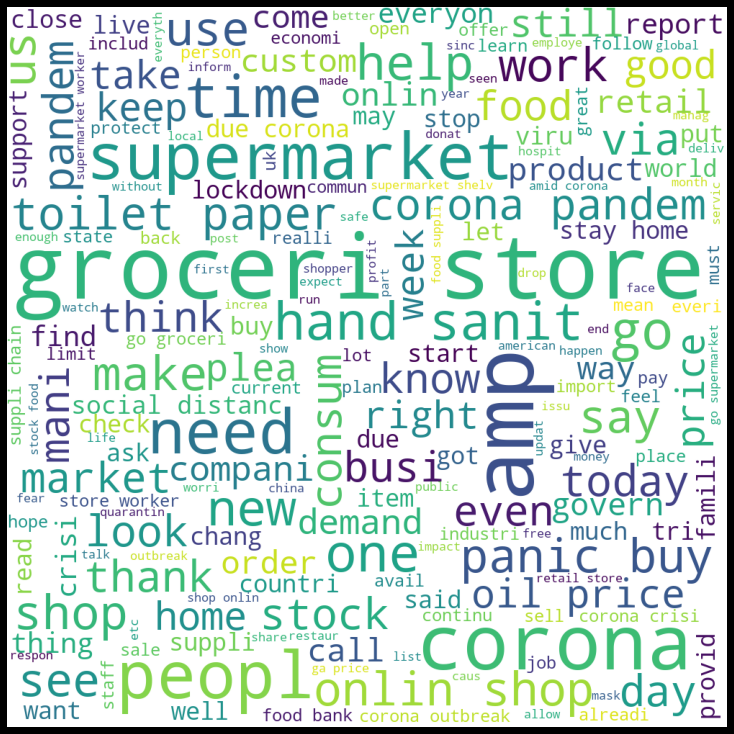

In [133]:
#All Words
plotwords(df['words'])

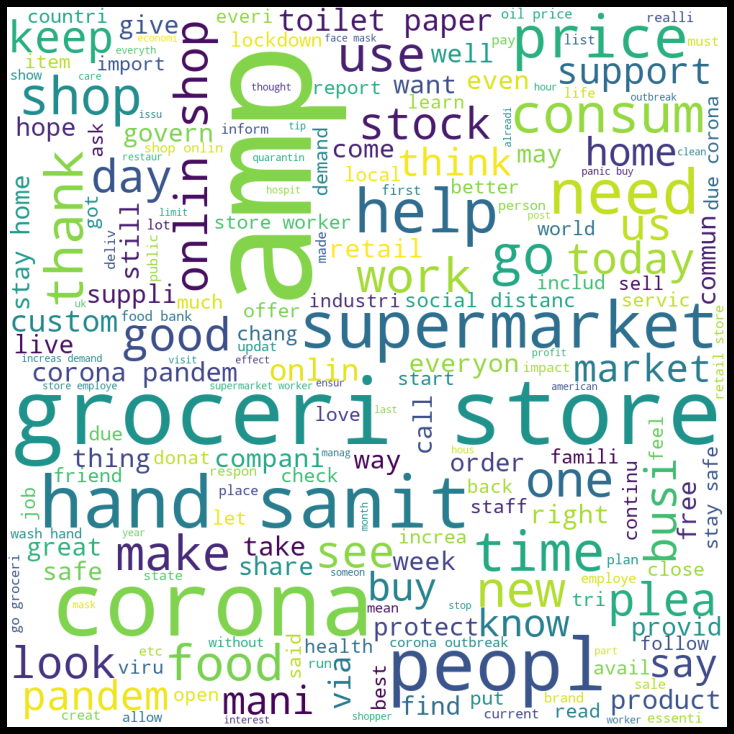

In [134]:
#Positive Words
plotwords(df[df['Ordinal_Sentiment']>0]['words'])

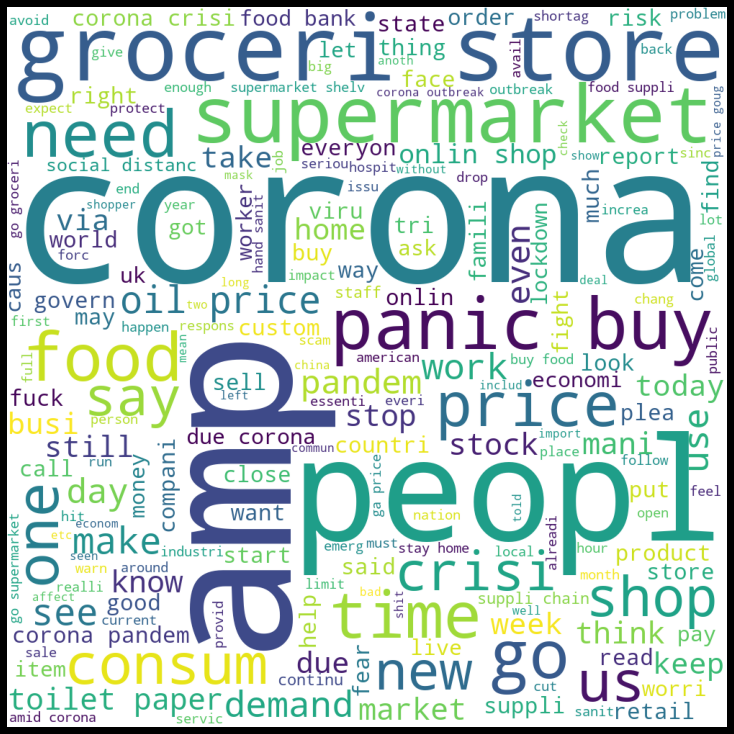

In [135]:
#Negative Words
plotwords(df[df['Ordinal_Sentiment']<0]['words'])

In [136]:
model_dict = {}

In [137]:
metric ='f1_macro'

In [138]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
params = {}
model_dict['Naive Bayes'] = [nb,params,metric]

# Logistic Reg
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
params = {'C': [0.1,1.0,10], 'l1_ratio': [0.5], 'max_iter': [1000,10000], 'penalty': ['l2','l1','elasticnet'], 'solver': ['saga']}
model_dict['Logistic Regression'] = [lr,params,metric]

#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
params = {'criterion': ['gini','entropy'], 'max_depth': [5,10], 'min_samples_leaf': [10], 'n_estimators': [50,80,120]}
model_dict['Random Forest'] = [rf,params,metric]

#XGB
from xgboost import XGBClassifier
xgb = XGBClassifier()
params = {'learning_rate': [0.01,0.1,0.5], 'max_depth': [5,10], 'n_estimators': [50,80,120], 'reg_lambda': [0.1,1,10], 'seed': [123]}
model_dict['XG Boost'] = [xgb,params,metric]

#SVM
from sklearn.svm import SVC
svc = SVC()
params = {'C': [0.1,1.0,10], 'kernel': ['rbf','polynomial']}
model_dict['SVM'] = [svc,params,metric]

#catboost
from catboost import CatBoostClassifier
cbc = CatBoostClassifier()
params = {}
model_dict['CatBoost'] = [cbc,params,metric]

#SGD
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier()
params = {}
model_dict['CatBoost'] = [sgdc,params,metric]

In [140]:
tweet_df.columns

Index(['corona', 'corona corona', 'corona toiletpap', 'lockdown', 'pandem',
       'retail', 'socialdistanc', 'stayhom', 'supermarket', 'toiletpap',
       'toiletpap corona', 'uk', 'amp', 'buy', 'consum', 'corona', 'demand',
       'food', 'get', 'go', 'groceri', 'groceri store', 'hand', 'help', 'home',
       'like', 'need', 'onlin', 'pandem', 'panic', 'peopl', 'price', 'sanit',
       'shop', 'stock', 'store', 'supermarket', 'time', 'us', 'work',
       'worker'],
      dtype='object')

In [141]:
gscv(model_dict,tweet_df,df['Ordinal_Sentiment'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


ValueError: ignored

In [142]:
mod = sm.load('Random Forest').best_estimator_

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


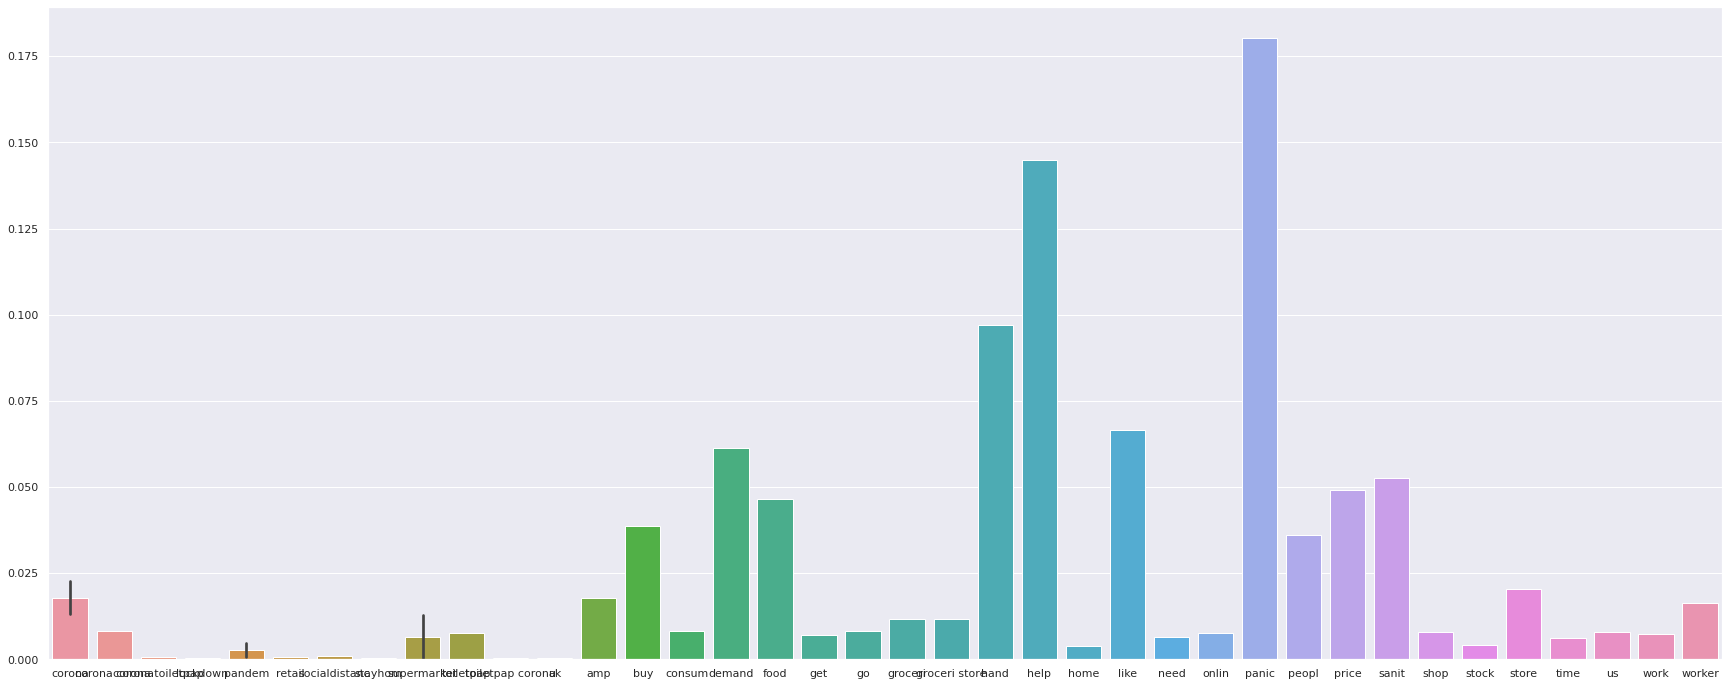

In [145]:
sns.barplot(list(tweet_df.columns),mod.feature_importances_)

array([0.01327015, 0.00831207, 0.00073872, 0.00026029, 0.00067256,
       0.00065106, 0.00092782, 0.00049253, 0.00033881, 0.00771156,
       0.00046028, 0.00040323, 0.01772251, 0.03873749, 0.00809039,
       0.02258523, 0.06140779, 0.0464217 , 0.00699402, 0.00826832,
       0.01168443, 0.01179563, 0.09700101, 0.14474101, 0.00375718,
       0.06643596, 0.00642978, 0.00755115, 0.00486953, 0.18027133,
       0.03603314, 0.04917787, 0.05269017, 0.00794947, 0.00413815,
       0.02040612, 0.01274392, 0.00627663, 0.00801475, 0.00730586,
       0.01626036])

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(1000)
# X_pca = pca.fit_transform(tweet_df)

In [ ]:
# @title Bad Classifier
# #Ordinal Class Predictor
# from sklearn.base import clone


# class OrdinalClassifier():
    
#     def __init__(self, clf):
#         self.clf = clf
#         self.clfs = {}
    
#     def fit(self, X, y):
#         self.unique_class = np.sort(np.unique(y))
#         if self.unique_class.shape[0] > 2:
#             for i in range(self.unique_class.shape[0]-1):
#                 # for each k - 1 ordinal value we fit a binary classification problem
#                 binary_y = (y > self.unique_class[i]).astype(np.uint8)
#                 # print(binary_y)
#                 clf = clone(self.clf)
#                 clf.fit(X, binary_y)
#                 self.clfs[i] = clf
    
#     def predict_proba(self, X):
#         clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
#         predicted = []
#         for i,y in enumerate(self.unique_class):
#             if i == 0:
#                 # V1 = 1 - Pr(y > V1)
#                 # print(clfs_predict)
#                 predicted.append(1 - clfs_predict[i][:,1])
#             elif i in [1,2,3]:
#                 # Vi = Pr(y > Vi-1) - Pr(y > Vi)
#                  predicted.append(clfs_predict[i-1][:,1] - clfs_predict[i][:,1])
#             else:
#                 # Vk = Pr(y > Vk-1)
#                 predicted.append(clfs_predict[y-1][:,1])
#         return np.vstack(predicted).T
    
#     def predict(self, X):
#         return np.argmax(self.predict_proba(X), axis=1)-2

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)
y_train_pred = nb.predict(X_train)
print(f'{accuracy_score(y_test,y_pred)} {accuracy_score(y_train,y_train_pred)}')

0.3392857142857143 0.4278511769172361


These are the Test and Train accuracies respectively

In [ ]:
from sklearn.naive_bayes import GaussianNB
oc = OrdinalClassifier(GaussianNB())
oc.fit(X_train,y_train)
y_pred = oc.predict(X_test)
y_train_pred = oc.predict(X_train)
print(f'{accuracy_score(y_test,y_pred)} {accuracy_score(y_train,y_train_pred)}')

0.23979591836734693 0.29779802581624903


In [ ]:
te = []
for x in y_test:
  if x >= 0:
    te.append(1)
  else:
    te.append(0)

In [ ]:
pr = []
for x in y_pred:
  if x >= 0:
    pr.append(1)
  else:
    pr.append(0)

In [ ]:
print(f'{accuracy_score(te,pr)}')

0.5473760932944607


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


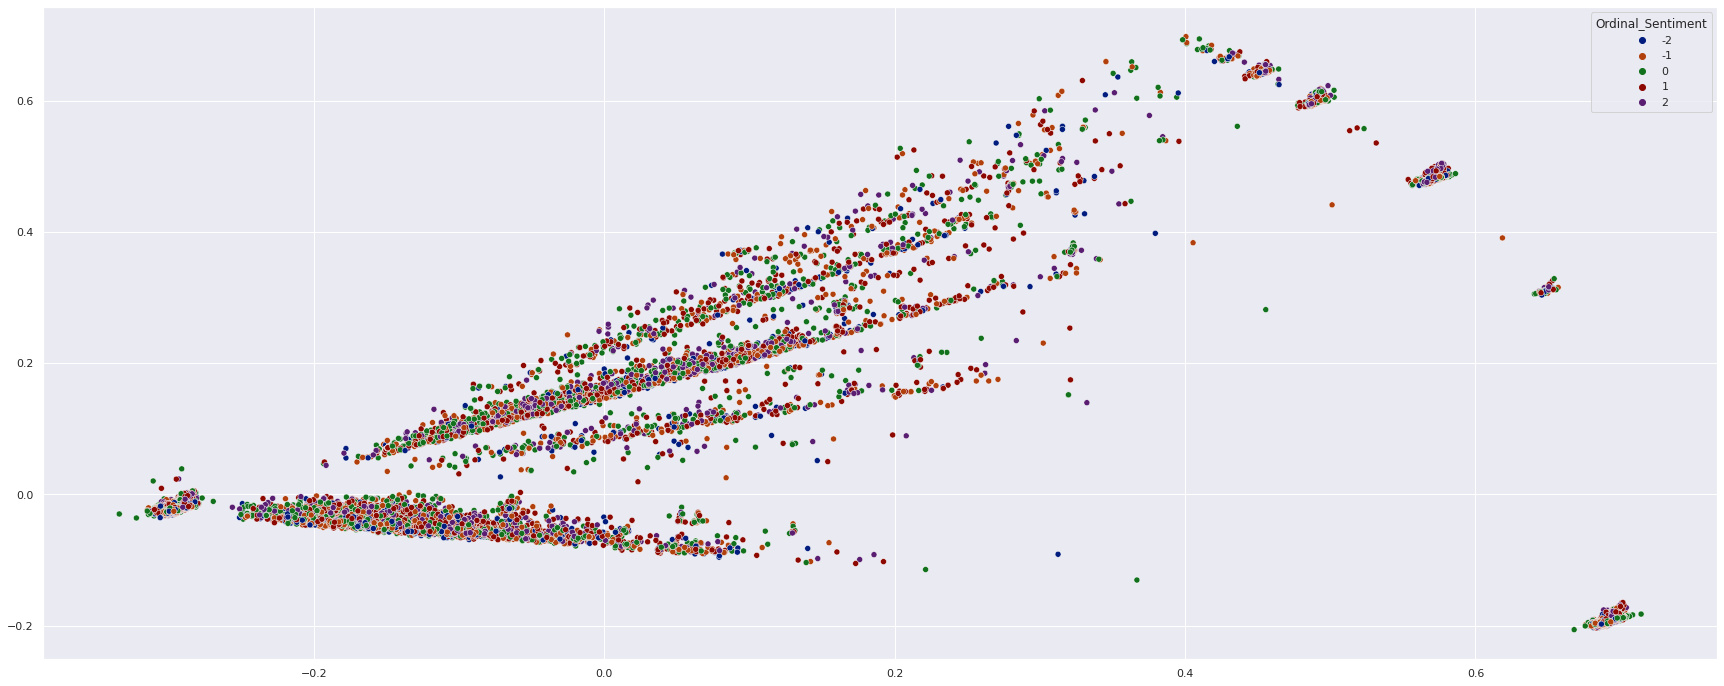

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(2)
X_pca = pca.fit_transform(tweet_df)
sns.scatterplot(X_pca[:,0],X_pca[:,1],hue=df['Ordinal_Sentiment'], palette='dark')

In [ ]:
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2)
# X_tnse = tsne.fit_transform(tweet_df)

In [ ]:
# from sklearn.svm import SVC
# svc = SVC(verbose=10)
# svc.fit(X_train,y_train)
# y_pred = svc.predict(X_test)
# y_train_pred = svc.predict(X_train)
# from sklearn.metrics import *
# accuracy_score(y_test,y_pred)
# accuracy_score(y_train,y_train_pred)